In [12]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

In [13]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

In [14]:
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

In [15]:
image_path = tf.keras.utils.get_file('rabbit11.jpg', 'https://www.apexvets.com/static/01b25338a546344045febed5a050629d/22896/AUG-A-SMF-is-your-rabbit-too-jumpy.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


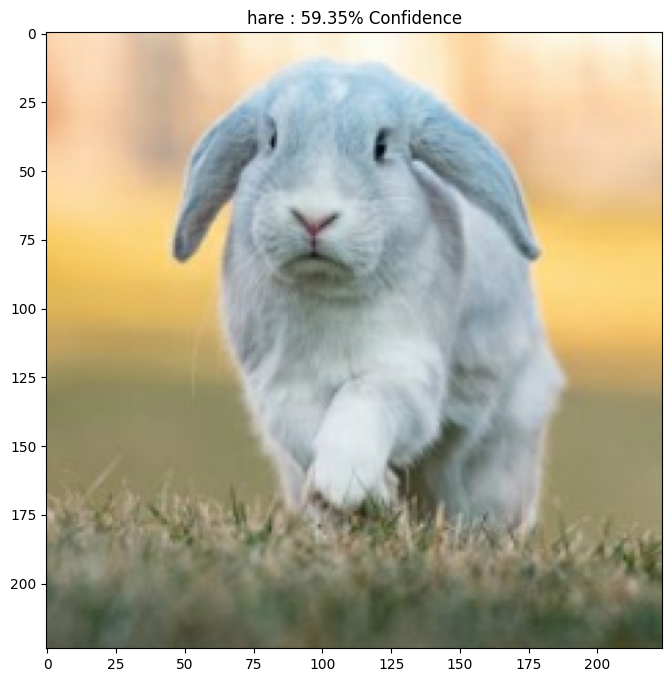

In [16]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

In [17]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  gradient = tape.gradient(loss, input_image)
  signed_grad = tf.sign(gradient)
  return signed_grad

The resulting perturbations can also be visualised.

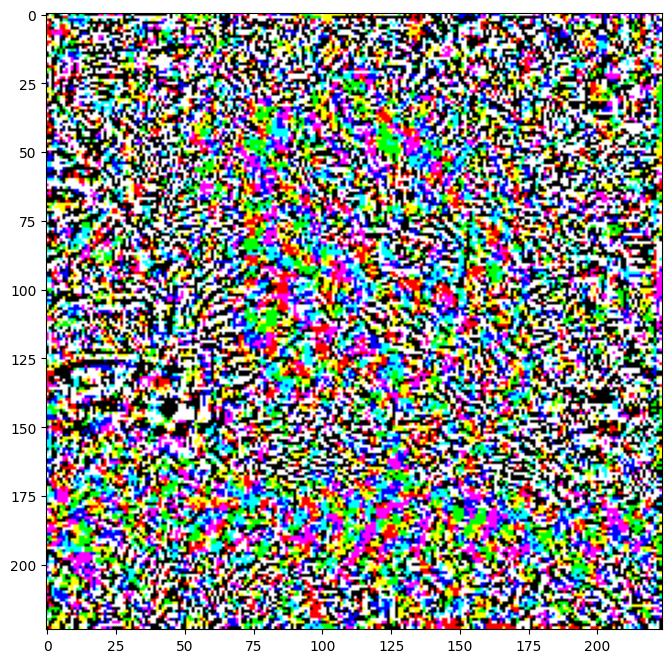

In [18]:
labrador_retriever_index = 208
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);

In [19]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

In [20]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])

Output hidden; open in https://colab.research.google.com to view.

In [21]:
def add_gaussian_noise(image, mean=0.0, std=0.1):
  noise = tf.random.normal(shape=tf.shape(image), mean=mean, stddev=std, dtype=tf.float32)
  noisy_image = image + noise
  noisy_image = tf.clip_by_value(noisy_image, -1.0, 1.0)
  return noisy_image

stddevs = [0.01, 0.05, 0.1, 0.2]
gaussian_descriptions = [f"Gaussian Noise (stddev={std})" for std in stddevs]

for std, desc in zip(stddevs, gaussian_descriptions):
  noisy_image = add_gaussian_noise(image, std=std)
  display_images(noisy_image, desc)


Output hidden; open in https://colab.research.google.com to view.